# Markov-Chain Monte Carlo in EasyVVUQ

**Author**: Vytautas Jancauskas, LRZ (jancauskas@lrz.de)

We have a model that returns an array of 50 integers where each is supposed to have come from a Poisson distribution with an unknown mean. The model has four input parameters ```a, b, c, d``` and the values of the means depend on the values of those parameters (albeit in some unknown to us way). 
    This situation seems common in practice in cases where the author of a simulation wants to show that their code in some way is validated by real world data. If they have observed data and they have a simulation for the phenomenon that produced that data and they have measurements of the inputs for the simulation they could use the procedure here to see if the real world "input" parameters fall within a reasonable range of the simulation input parameters. For more information on Markov-Chain Monte Carlo you can start at the Wikipedia [page](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).

In [1]:
import numpy as np

In [2]:
def model(params):
    import numpy as np
    a = int(params['a'])
    b = int(params['b'])
    c = int(params['c'])
    d = int(params['d'])
    x = np.linspace(0, 1, 50)
    return {'Values' : list(np.random.poisson(
        a * (0.5 * np.sin(2.0 * np.pi * x) + 1.0) +\
        b * (0.5 * np.sin(4.0 * np.pi * x) + 1.0) +\
        c * (0.5 * np.sin(6.0 * np.pi * x) + 1.0) +\
        d * (0.5 * np.sin(8.0 * np.pi * x) + 1.0)))}

If we plot the values returned by the model with ```a = b = c = d = 50``` and repeat this 20 times we might get something like the figure below.

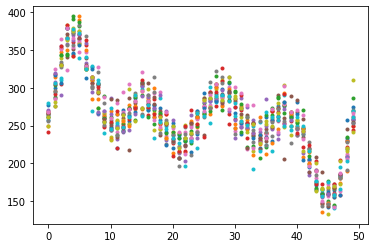

In [3]:
import matplotlib.pyplot as plt
for _ in range(20):
    plt.plot(model({'a': 50, 'b': 80, 'c': 50, 'd': 80})['Values'], '.')

Then we have an array of 50 values that came from the model. With ```a = 50, b = 80, c = 50 and d = 80```. We will treat them as our observed data. We want to know what input parameters of the model are most likely to result in the values in the ```observed``` array. Because suppose we forgot.

In [4]:
observed = np.array([248, 311, 344, 370, 375, 369, 302, 306, 285, 281, 258, 248, 254,
       273, 292, 268, 312, 269, 230, 244, 227, 219, 247, 233, 225, 238,
       271, 307, 294, 299, 248, 249, 271, 255, 231, 225, 243, 279, 271,
       294, 237, 247, 197, 180, 161, 168, 178, 207, 204, 258])

We are interested in $\mathbb{E}(X | y)$ with $X = [A, B, C, D]^T$ where $A, B, C, D$ are the random variables representing the input parameters. For this we need to know the probability density $f_{X|y}$ where $y$ are our observed values. From Bayes theorem it follows that $f_{X|y}$ is proportional to $f_{Y|X}(y|X)f(X)$. We usually can infer $f(X)$ (the prior probability) in advance, in this case we will leave them flat. We will use Markov-Chain Monte Carlo (MCMC) to approximate the probability density $f_{X|y}(x)$. We assume that $y$ (our observed data) is 50 numbers from 50 Poisson distributions with unknown means. We will estimate those means by running the model multiple times and calculating the sample mean because that is the MLE estimate for a Poisson distributed random variable. Suppose we have $\hat{\lambda}_i$ that is the estimate. Then we have $f_{X|y}(x) = \prod_{i = 1}^{50} \frac{\hat\lambda_i^{y_i} \exp(-\hat\lambda_i)}{{y_i}!}$ where $\lambda_i$ is the estimated Poisson parameter for th $i$-th output variable and $y_i$ is the $i$-th value in the observed vector. Since it is often more convenient to work with log-likelihoods we arrive at $\sum_{i = 1}^{50} \left(y_i \log(\hat\lambda_i) - \hat\lambda_i - \log({y_i}!)\right)$.

## Sampling

First, mandatory imports.

In [5]:
import easyvvuq as uq
from easyvvuq.actions import ExecutePython, Actions
import scipy.special
import chaospy as cp
import numpy as np
import pandas as pd
import os
import json

We define parameter specification, encoder, decoder and the campaign object. See the more detailed tutorials on these EasyVVUQ elements [here](basic_tutorial.ipynb) and [here](vector_qoi_tutorial.ipynb).

In [6]:
params = {
    "a": {"type": "float", "min": 0, "max": 100, "default": 50},
    "b": {"type": "float", "min": 0, "max": 100, "default": 50},
    "c": {"type": "float", "min": 0, "max": 100, "default": 50},
    "d": {"type": "float", "min": 0, "max": 100, "default": 50},
    "outfile": {"type": "string", "default": "output.csv"},
    "ensemble_id": {"type": "integer", "default": 0},
    "chain_id": {"type": "integer", "default": 0}
}
actions = Actions(ExecutePython(model))
campaign = uq.Campaign(name="mcmc", actions=actions, params=params, work_dir='.')

We need initial values for our MCMC chains. Here we simply set it to a uniformly distributed value from the valid range for that parameter. Note that each input parameter gets an array of 5 numbers because we will use 5 chains later on.

In [7]:
vary_init = {
    "a": np.random.uniform(0, 100, size=5),
    "b": np.random.uniform(0, 100, size=5),
    "c": np.random.uniform(0, 100, size=5),
    "d": np.random.uniform(0, 100, size=5)
}

Then we need to define the proposal distribution. It can be arbitrary (for example assymetrical). This is conditional on current chain position in the search space. In this case we will use a normal distribution with $mu = a, b, c, d$ and $\sigma = 5$.

In [8]:
def proposal(x, b=2.5):
    return cp.J(cp.Normal(x['a'], b), 
                cp.Normal(x['b'], b), 
                cp.Normal(x['c'], b), 
                cp.Normal(x['d'], b))

Next we want to construct the likelihood function. This function describes the probability that the observed data came from our model (assuming some fixed input parameters). In this case we will need the estimate of the Poisson mean for each of the 50 outputs of the simulation. These are the parameters $\lambda$. Once we have those it is trivial to see what is the probability that each output came from a corresponding distribution. We then just multiply them together and take the logarithm (because of numerical issues this is preferable to straight up multiplying). This formula was derived above.

In [9]:
def get_likelihood(observed):
    def likelihood(lmbda):
        return (observed * np.log(lmbda) - lmbda - 
                scipy.special.gammaln(observed + 1.0)).sum()
    return likelihood

Finally we put everything together. Note the estimator parameter to the MCMCSampler class. It is used to produce the estimate for the mean of the Poisson distribution. In this case we use sample mean because that is the MLE for Poisson $\lambda$ parameter.

In [10]:
mcmc_sampler = uq.sampling.MCMCSampler(
    vary_init, proposal, 'Values', n_chains=5,
    likelihood=get_likelihood(observed), 
    estimator=lambda x: np.mean(x))
sampler = uq.sampling.ReplicaSampler(mcmc_sampler, replicas=20)
campaign.set_sampler(sampler)

When we have workflows where each sampling stage relies on the results of the previous one (as is the case with MCMC) we need to call iterate on the campaign object and then use the Python keyword next to advance to the next sampling stage. This will return action statuses and we need to wait for them to finish in order to proceed.

In [11]:
iterator = campaign.iterate(mark_invalid=True, sequential=True)

In [12]:
for _ in range(10000):
    next(iterator).collate()

/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:12

/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:12

/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:12

/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:12

/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:12

/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:123: RuntimeWarning: invalid value encountered in double_scalars
  r = min(1.0, (f_y / self.f_x[chain_id]) * (q_xy / q_yx))
/Users/di73kuj2/Programming/EasyVVUQ/easyvvuq/sampling/mcmc.py:12

## Analysis

Let us now save our progress so that we do not lose it. This way we can continue the tutorial just from this point onward and not redo the sampling stage.

In [ ]:
campaign.save_state('mcmc_state.json')

In [ ]:
campaign = uq.Campaign(state_file='mcmc_state.json')

After calling analyse we will get an instance of MCMCAnalysisResults that contains information about our chains. It also lets us plot and analyse that data.

In [ ]:
result = campaign.analyse()

We will now plot the chains for each parameter. We can see that they indeed seem to converge to the input parameters used to generate observed data. Which was $a = 50, b = 80, c = 50, d = 80$.

In [ ]:
result.plot_chains('a')

In [ ]:
result.plot_chains('b')

In [ ]:
result.plot_chains('c')

In [ ]:
result.plot_chains('d')

We can also plot histograms of the parameters. This can let us determine the shape of the distribution of that parameter and determine confidence intervals, etc.

In [ ]:
result.plot_hist('a', skip=1000)

In [ ]:
result.plot_hist('b', skip=1000)

In [ ]:
result.plot_hist('c', skip=1000)

In [ ]:
result.plot_hist('d', skip=1000)